In [1]:
import os
import librosa
import numpy as np
import random
import re
import pywt
import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook

def extract_info_from_filename(filename):
    # Define a regex pattern to match the desired format
    pattern=re.compile(r'^ica_(Q\d+)_(x\d+).wav$', re.IGNORECASE)
    
    # Use the regex pattern to extract information
    match = re.match(pattern, filename)
    
    if match:
        qi_part = match.group(1)
        specifier = match.group(2)
        return qi_part, specifier
    else:
        return None, None
    

def load_data(data_folder, code_to_load="Q0"):
    data = {}
    
        
    for file in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file)
        code, specifier = extract_info_from_filename(file)
        
        if not code_to_load is None:
            if not code in code_to_load:
                continue
                
        data[specifier] = librosa.load(file_path, sr=None)
                              
    return data

# Define the path to the data folder
data_folder = "data"
data_folder_path = os.path.join(os.pardir, data_folder)

code_to_load=set(["Q1"])
data = load_data(data_folder_path, code_to_load)

In [2]:
from IPython.display import Audio
import os

for key in data:
    sound = data[key]
    print(key + ':')
    display(Audio(data=sound[0], rate=sound[1]))
    

x1:


x2:


<IPython.core.display.Javascript object>


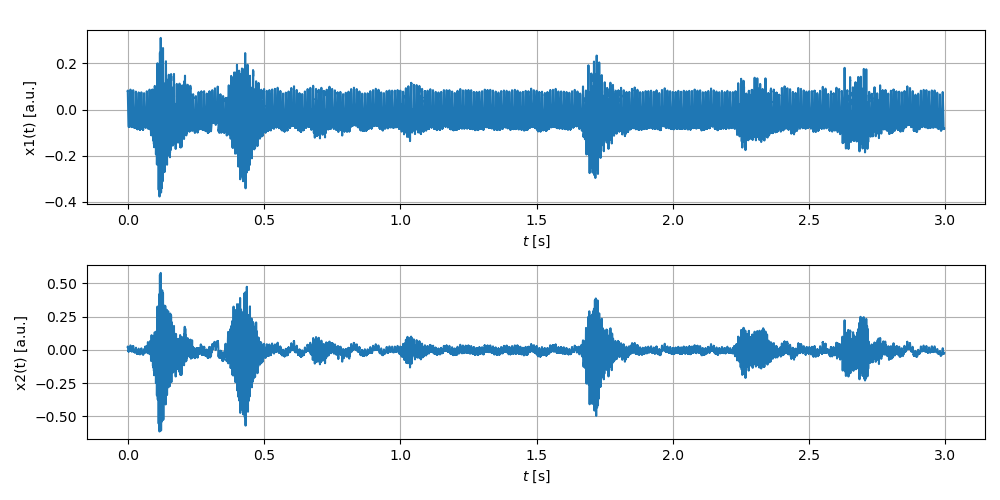

<IPython.core.display.Javascript object>


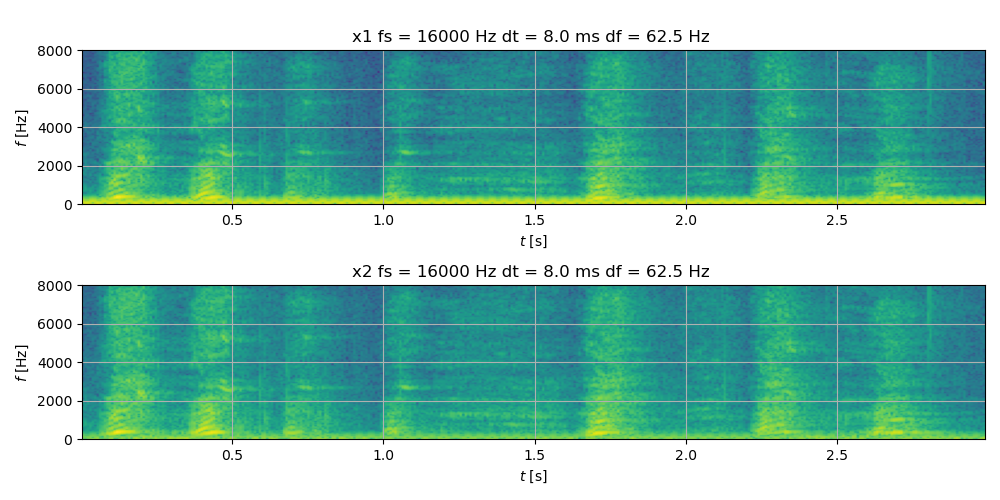

In [3]:
def plot_data_time_domain(data, title=''):
    num_entries = len(data.keys())
    keys = list(data.keys())
    
    fig, axes = plt.subplots(2, int((num_entries)//2), figsize=(10, 5*(num_entries)//2))
    axes = axes.ravel()
    fig.suptitle(title)
    
    for i in range(num_entries):
        key = keys[i]
        fs = data[key][1] # key: (y, fs)
        y = data[key][0]
        
        t = np.linspace(0, (len(y)-1)/fs, len(y))
        
        axes[i].plot(t, y)
        axes[i].grid('on')
        axes[i].set_xlabel('$t$ [s]')
        axes[i].set_ylabel(f'{key}(t) [a.u.]')
        #axes[i].set_title(key+ f' fs = {fs} [Hz]')
    plt.tight_layout()
    plt.show()
plot_data_time_domain(data)  

def plot_data_specgram(data,NFFT=256, window=matplotlib.mlab.window_hanning, noverlap=128, title=''):
    num_entries = len(data.keys())
    keys = list(data.keys())
    
    fig, axes = plt.subplots(2, int((num_entries)//2), figsize=(10, 5*(num_entries)//2))
    axes = axes.ravel()
    fig.suptitle(title)
    
    for i in range(num_entries): 
        key = keys[i]
        fs = data[key][1] # key: (y, fs)
        y = data[key][0]
        
        t = np.linspace(0, (len(y)-1)/fs, len(y))
        axes[i].specgram(x=y, Fs=fs, NFFT=NFFT, window=window, noverlap=noverlap, pad_to=2048)
        axes[i].grid('on')
        axes[i].set_xlabel('$t$ [s]')
        axes[i].set_ylabel('$f$ [Hz]')
        axes[i].set_title(key+ f' fs = {fs} Hz' + f" dt = {(NFFT-noverlap)*1000/fs} ms df = {fs/NFFT} Hz ")
        
    plt.tight_layout()
    plt.show()

NFFT = 256
plot_data_specgram(data,NFFT, np.blackman(NFFT), noverlap=NFFT//2)

<IPython.core.display.Javascript object>


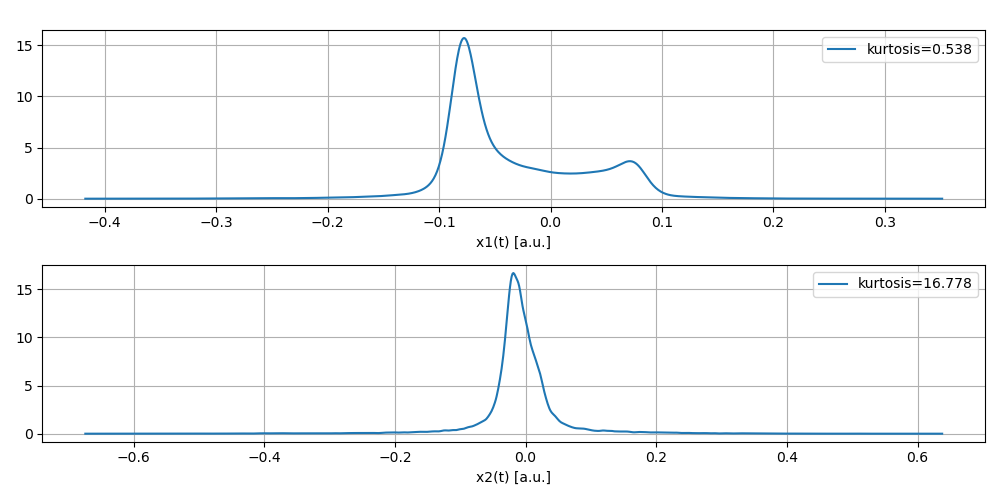

<IPython.core.display.Javascript object>


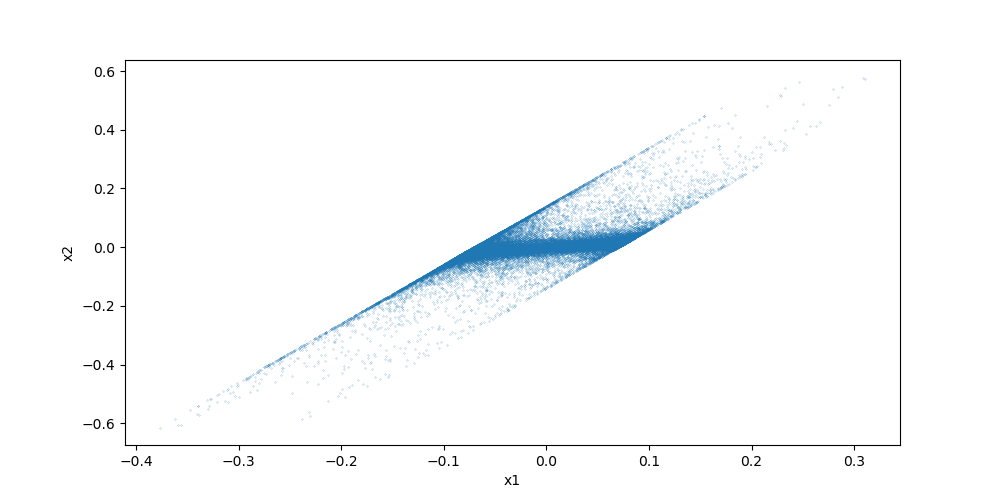

In [4]:
import numpy as np
import scipy

from KDEpy import FFTKDE

def plot_data_pdf(data, title=''):
    num_entries = len(data.keys())
    keys = list(data.keys())
    
    fig, axes = plt.subplots(2, int((num_entries)//2), figsize=(10, 5*(num_entries)//2))
    axes = axes.ravel()
    fig.suptitle(title)
    
    for i in range(num_entries):
        key = keys[i]
        fs = data[key][1] # key: (y, fs)
        y = data[key][0]
        
        kurtosis = np.round(scipy.stats.kurtosis(y), 3)
        
        t, x = FFTKDE(kernel="gaussian", bw="silverman").fit(y).evaluate()
        axes[i].plot(t, x, label = f'kurtosis={kurtosis}')
        axes[i].grid('on')
        axes[i].set_xlabel(f'{key}(t) [a.u.]')
        #axes[i].set_title(key+ f' fs = {fs} [Hz]')
        axes[i].legend()
    plt.tight_layout()
    plt.show()
    

def plot_phase_space(data, title=''):
    keys = list(data.keys())
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(data[keys[0]][0], data[keys[1]][0], '.', markersize=.3)
    plt.xlabel(keys[0])
    plt.ylabel(keys[1])
    plt.show()
    

plot_data_pdf(data, title='')
plot_phase_space(data)

In [5]:
from pymanopt.optimizers import NelderMead
from pymanopt.manifolds import Sphere
from pymanopt.manifolds.manifold import Manifold
from numpy.linalg import norm, svd, inv
import torch

x = np.c_[data['x1'][0], data['x2'][0]]

torch.Size([2])
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -2.2732755693810995e-03    2.85386558e-03    
   2         -5.3407557823831296e-03    3.28109485e-03    
   3         -6.5850631386890606e-03    1.04805270e-03    
   4         -6.6892863538215658e-03    8.71537423e-05    
   5         -6.6899948473217452e-03    5.64526595e-06    
   6         -6.6899978195472630e-03    3.64960798e-07    
   7         -6.6899978319697106e-03    2.35941597e-08    
   8         -6.6899978320215754e-03    1.52532645e-09    
   9         -6.6899978320218018e-03    9.86100271e-11    
Terminated - min grad norm reached after 9 iterations, 0.09 seconds.

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -8.9608847083242047e+00    6.09649979e+00    
   2         -1.1640362378084555e+01    3.28167205e+00    
 

<IPython.core.display.Javascript object>


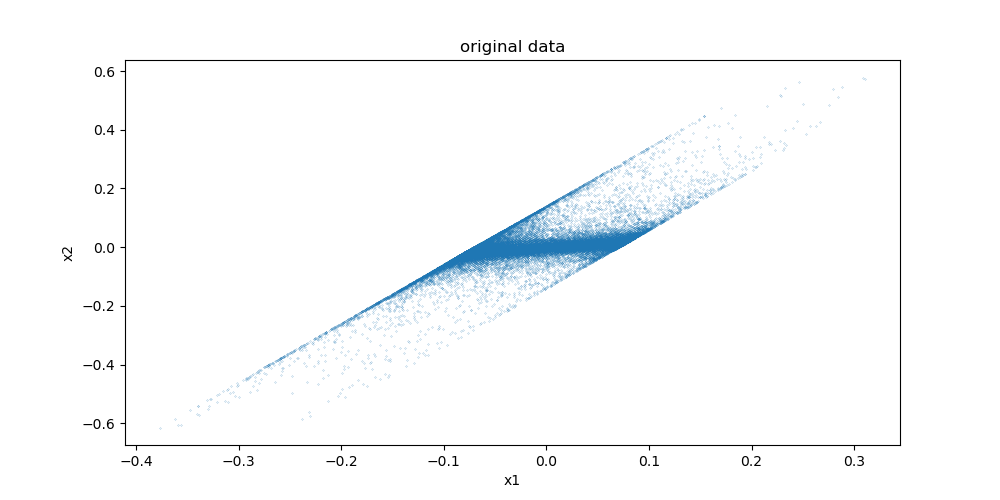

Rotation matrix U^T: 
 [[ 0.70872464  0.70548521]
 [-0.70548521  0.70872464]]


<IPython.core.display.Javascript object>


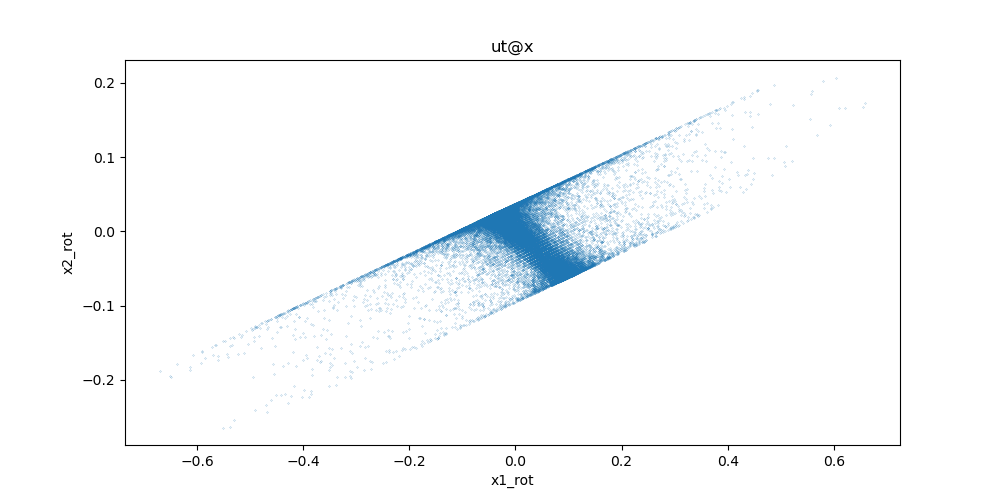

Whitening matrix sigma: 
 [[12.22607376  0.        ]
 [ 0.         27.20383244]]


<IPython.core.display.Javascript object>


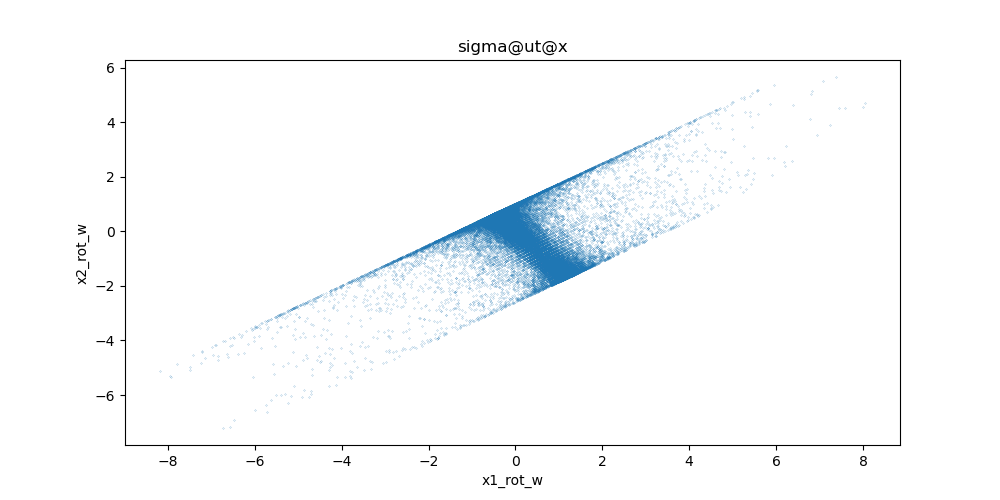

Rotation matrix V: 
 [[ 0.60365811 -0.7972433 ]
 [-0.7972433  -0.60365811]]


<IPython.core.display.Javascript object>


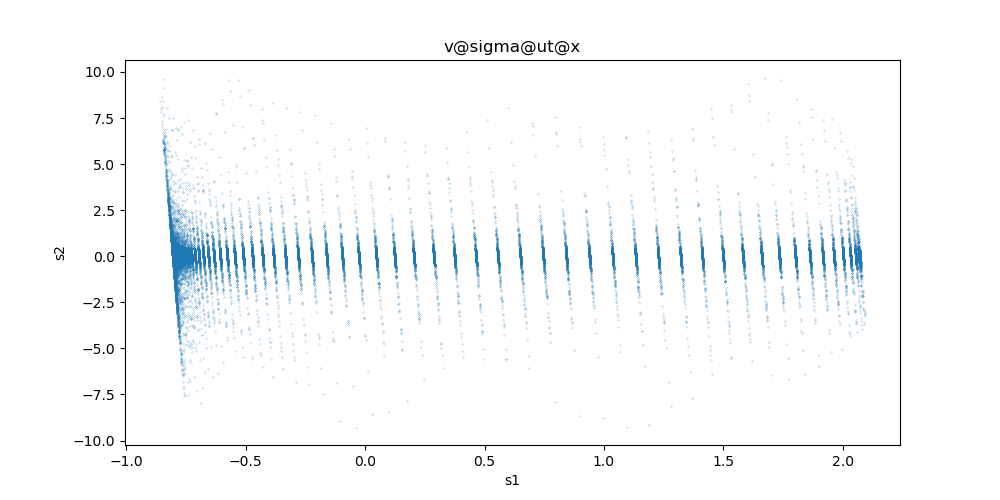

Inverted matrix A: 
 [[ 20.53126399 -10.16413107]
 [  4.67729771 -18.51501832]]


In [6]:
# Make sure to install required libraries first:
# pip install torch pymanopt

import torch
import pymanopt
from pymanopt import Problem
from pymanopt.optimizers import SteepestDescent, ParticleSwarm, ConjugateGradient



import torch
import pymanopt
from pymanopt import Problem
from pymanopt.optimizers import SteepestDescent

def ica_pymanopt(X, num_components=None, max_iter=500, tol=1e-6):
    """
    Perform Independent Component Analysis (ICA) using the SVD approach.

    Parameters:
    - X: Input data matrix (n_samples x n_features).
    - num_components: Number of independent components to extract.
                      If None, use all components (default is None).
    - max_iter: Maximum number of iterations for the FastICA algorithm (default is 500).
    - tol: Tolerance to declare convergence (default is 1e-6).

    Returns:
    - S: Matrix of independent components (n_samples x num_components).
    """
    first_elem = torch.tensor(np.array([1, 0]), dtype=torch.double)
    print(first_elem.shape)
    # Select the number of components
    if num_components is None:
        num_components = min(X.shape[0], X.shape[1])
        
        
    manifold = pymanopt.manifolds.Stiefel(num_components,  num_components)
    @pymanopt.function.pytorch(manifold)
    def maximize_variance(ut):
        return -first_elem@torch.var(ut@X_centered.t(), dim=1)
    
    @pymanopt.function.pytorch(manifold)
    def maximize_kurtosis(u):
        mean = torch.mean(u@Z_whitened)
        return -torch.mean((u@Z_whitened-mean) ** 4)
                           
    

    # Convert data to PyTorch tensor
    X_tensor = torch.tensor(X, dtype=torch.double)

    # Center the data
    X_centered = X_tensor - torch.mean(X_tensor, dim=0)

    
    problem = Problem(manifold=manifold, cost=maximize_variance)
    solver = ConjugateGradient(min_gradient_norm=1e-10, min_step_size=1e-20)
    ut = torch.tensor(solver.run(problem).point)
    
    Z = ut@X_centered.t()
    sigma = torch.diag(1/torch.std(Z, dim=1))
    
    Z_whitened = sigma@Z

    problem = Problem(manifold=manifold, cost=maximize_kurtosis)
    solver = ConjugateGradient(min_gradient_norm=1e-10, min_step_size=1e-20)
    v = torch.tensor(solver.run(problem).point)
    

    # Get the independent components
    
    S = v @ Z_whitened 
    Ainv = v@sigma@ut
    
    S = S.t().detach().numpy()
    Z = Z.t().detach().numpy()
    Z_whitened = Z_whitened.t().detach().numpy()
    Ainv = Ainv.detach().numpy()
    v = v.detach().numpy()
    ut = ut.detach().numpy()
    sigma = sigma.detach().numpy()
    return S, Z, Z_whitened, Ainv, v, sigma, ut

# Example usage:
# Assume X is your data matrix (n_samples x n_features)
# S is the matrix of independent components
# S = ica_pymanopt(X, num_components=3)


# Example usage:
# Assume X is your data matrix (n_samples x n_features)
# S is the matrix of independent components
# S = ica_pymanopt(X, num_components=3)


# Example usage:
# Assume X is your data matrix (n_samples x n_features)
# S is the matrix of independent components
# S = ica_pymanopt(X, num_components=3)
s, z, z_whitened, Ainv, v, sigma, ut = ica_pymanopt(x)
s_data = {'s1':(s[:, 0], 8000), 's2':(s[:, 1], 8000)}



def visualize_ICA(s, z, z_w, Ainv, v, sigma, ut, x):
    plot_phase_space({'x1':(x[:,0], -1), 
                      'x2':(x[:,1], -1)},
                     title='original data')
    
    print(f'Rotation matrix U^T: \n {ut}')
    
    plot_phase_space({'x1_rot':(z[:,0], -1), 
                      'x2_rot':(z[:,1], -1)},
                     title=r'ut@x')
    
    print(f'Whitening matrix sigma: \n {sigma}')
    
    plot_phase_space({'x1_rot_w':(z_w[:,0], -1), 
                      'x2_rot_w':(z_w[:,1], -1)}, 
                     title=r'sigma@ut@x')
    
    print(f'Rotation matrix V: \n {v}')
    
    plot_phase_space({'s1':(s[:,0], -1), 
                      's2':(s[:,1], -1)}, 
                     title=r'v@sigma@ut@x')
    print(f'Inverted matrix A: \n {Ainv}')
    
visualize_ICA(s, z, z_whitened, Ainv, v, sigma, ut, x)

<IPython.core.display.Javascript object>


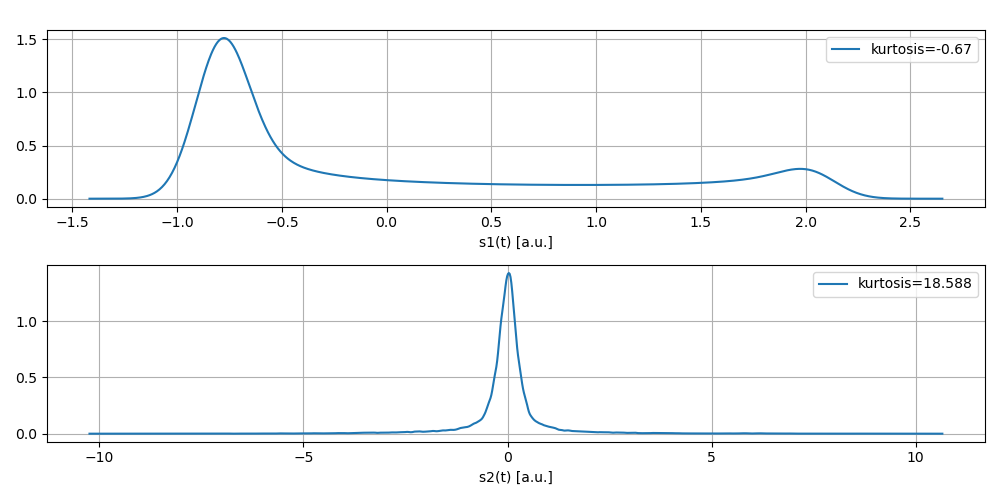

In [7]:
plot_data_pdf(s_data)

In [8]:
for key in s_data:
    sound = s_data[key]
    print(key + ':')
    display(Audio(data=sound[0], rate=sound[1]))
    

s1:


s2:


<IPython.core.display.Javascript object>


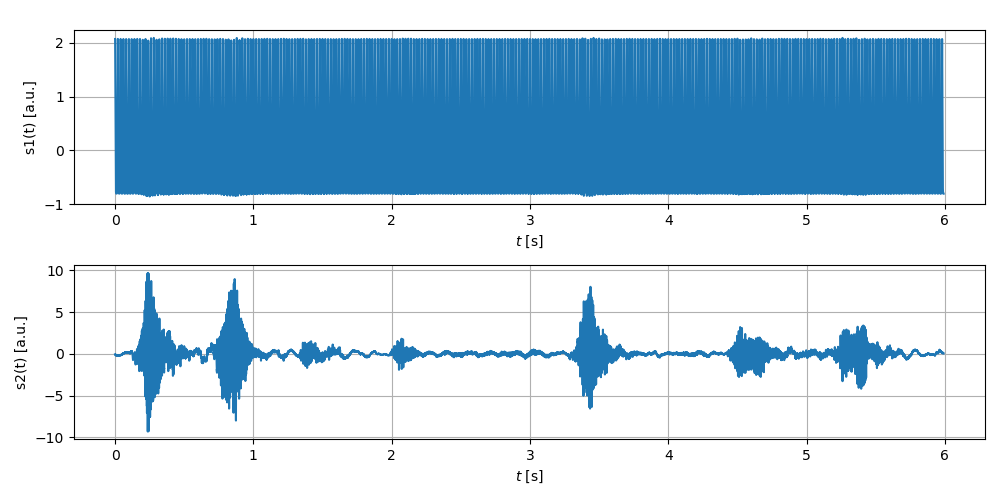

<IPython.core.display.Javascript object>


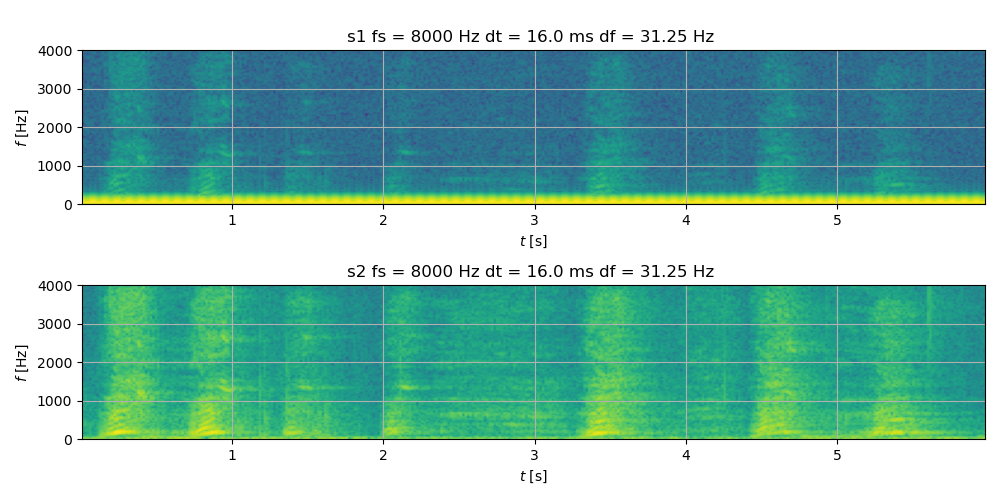

In [9]:
plot_data_time_domain(s_data)  
NFFF = 64
plot_data_specgram(s_data,NFFT, np.blackman(NFFT), noverlap=NFFT//2)